In [1]:
import torch
import os

c:\Users\Giordano\Anaconda3\envs\MACHINELEARNING\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#only in google colab
!git clone https://github.com/Giordano-Cicchetti/MaskTune_NN/

Cloning into 'MaskTune_NN'...
remote: Enumerating objects: 61, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (41/41), done.
remote: Total 61 (delta 21), reused 47 (delta 17), pack-reused 0
Unpacking objects: 100% (61/61), 2.19 MiB | 4.79 MiB/s, done.


In [3]:
#only on google colab
!cp MaskTune_NN/MNIST/* /content -r
!rm MaskTune_NN/ -r

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
!pip install grad-cam  

In [3]:
from train import *
train= TrainBaseERM(device)




Start loading data of train dataset in main memory




start creating and saving test dataset of BiasedMnist




Start loading data of test dataset in main memory




start creating and saving test dataset of BiasedMnist




Start loading data of test dataset in main memory




In [5]:
train.val_dataset.targets[0:100]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [6]:
train.train_erm(epochs=10)

validation epoch 0: 100%|██████████| 94/94 [00:04<00:00, 21.70it/s, loss=0.0155, accuracy=0.995] 


lr: 0.01


validation epoch 1: 100%|██████████| 94/94 [00:04<00:00, 21.49it/s, loss=0.012, accuracy=0.996]  


lr: 0.01


validation epoch 2: 100%|██████████| 94/94 [00:04<00:00, 21.40it/s, loss=0.0117, accuracy=0.996] 


lr: 0.01


validation epoch 3: 100%|██████████| 94/94 [00:04<00:00, 21.61it/s, loss=0.0099, accuracy=0.997] 


lr: 0.01


validation epoch 4: 100%|██████████| 94/94 [00:04<00:00, 21.83it/s, loss=0.00981, accuracy=0.997]


lr: 0.01


validation epoch 5: 100%|██████████| 94/94 [00:04<00:00, 21.38it/s, loss=0.00884, accuracy=0.997]


lr: 0.01


validation epoch 6: 100%|██████████| 94/94 [00:04<00:00, 22.01it/s, loss=0.0101, accuracy=0.998] 


lr: 0.01


validation epoch 7: 100%|██████████| 94/94 [00:04<00:00, 21.08it/s, loss=0.0101, accuracy=0.997] 


lr: 0.01


validation epoch 8: 100%|██████████| 94/94 [00:04<00:00, 20.46it/s, loss=0.00949, accuracy=0.998]


lr: 0.01


validation epoch 9: 100%|██████████| 94/94 [00:04<00:00, 19.88it/s, loss=0.0102, accuracy=0.998] 

lr: 0.01


In [7]:
train.train_erm(resume=True,best_resume_checkpoint_path="best_erm_model.pt",last_resume_checkpoint_path="last_erm_model.pt")

validation epoch 10: 100%|██████████| 94/94 [00:04<00:00, 21.86it/s, loss=0.0108, accuracy=0.997]


lr: 0.01


validation epoch 11: 100%|██████████| 94/94 [00:04<00:00, 21.12it/s, loss=0.011, accuracy=0.997]  


lr: 0.01


validation epoch 12: 100%|██████████| 94/94 [00:04<00:00, 20.72it/s, loss=0.00976, accuracy=0.998]


lr: 0.01


validation epoch 13: 100%|██████████| 94/94 [00:04<00:00, 21.35it/s, loss=0.0101, accuracy=0.998] 


lr: 0.01


validation epoch 14: 100%|██████████| 94/94 [00:04<00:00, 21.01it/s, loss=0.0104, accuracy=0.998] 


lr: 0.01


validation epoch 15: 100%|██████████| 94/94 [00:04<00:00, 21.87it/s, loss=0.0102, accuracy=0.998] 


lr: 0.01


validation epoch 16: 100%|██████████| 94/94 [00:04<00:00, 20.44it/s, loss=0.0105, accuracy=0.998] 


lr: 0.01


validation epoch 17: 100%|██████████| 94/94 [00:04<00:00, 21.14it/s, loss=0.0105, accuracy=0.998] 


lr: 0.01


validation epoch 18: 100%|██████████| 94/94 [00:04<00:00, 19.98it/s, loss=0.0103, accuracy=0.998] 


lr: 0.01


validation epoch 19: 100%|██████████| 94/94 [00:04<00:00, 20.09it/s, loss=0.0105, accuracy=0.997]


lr: 0.01


validation epoch 20: 100%|██████████| 94/94 [00:04<00:00, 21.31it/s, loss=0.0102, accuracy=0.998] 


lr: 0.01


validation epoch 21: 100%|██████████| 94/94 [00:04<00:00, 21.45it/s, loss=0.0108, accuracy=0.997] 


lr: 0.01


validation epoch 22: 100%|██████████| 94/94 [00:04<00:00, 20.08it/s, loss=0.0109, accuracy=0.998] 


lr: 0.01


validation epoch 23: 100%|██████████| 94/94 [00:04<00:00, 20.52it/s, loss=0.0105, accuracy=0.998] 


lr: 0.01


validation epoch 24: 100%|██████████| 94/94 [00:04<00:00, 21.71it/s, loss=0.0104, accuracy=0.997] 


lr: 0.005


validation epoch 25: 100%|██████████| 94/94 [00:04<00:00, 18.91it/s, loss=0.0105, accuracy=0.998] 


lr: 0.005


validation epoch 26: 100%|██████████| 94/94 [00:04<00:00, 19.65it/s, loss=0.0108, accuracy=0.997] 


lr: 0.005


validation epoch 27: 100%|██████████| 94/94 [00:04<00:00, 20.18it/s, loss=0.0102, accuracy=0.998] 


lr: 0.005


validation epoch 28: 100%|██████████| 94/94 [00:04<00:00, 21.64it/s, loss=0.0104, accuracy=0.998] 


lr: 0.005


validation epoch 29: 100%|██████████| 94/94 [00:04<00:00, 21.74it/s, loss=0.0105, accuracy=0.998] 


lr: 0.005


validation epoch 30: 100%|██████████| 94/94 [00:04<00:00, 20.90it/s, loss=0.0105, accuracy=0.998] 


lr: 0.005


validation epoch 31: 100%|██████████| 94/94 [00:04<00:00, 21.60it/s, loss=0.0102, accuracy=0.998] 


lr: 0.005


validation epoch 32: 100%|██████████| 94/94 [00:04<00:00, 20.63it/s, loss=0.0103, accuracy=0.998] 


lr: 0.005


validation epoch 33: 100%|██████████| 94/94 [00:04<00:00, 21.40it/s, loss=0.0108, accuracy=0.997] 


lr: 0.005


validation epoch 34: 100%|██████████| 94/94 [00:04<00:00, 20.27it/s, loss=0.0103, accuracy=0.998] 


lr: 0.005


validation epoch 35: 100%|██████████| 94/94 [00:04<00:00, 20.90it/s, loss=0.0104, accuracy=0.998] 


lr: 0.005


validation epoch 36: 100%|██████████| 94/94 [00:04<00:00, 21.35it/s, loss=0.0101, accuracy=0.998] 


lr: 0.005


validation epoch 37: 100%|██████████| 94/94 [00:04<00:00, 19.42it/s, loss=0.0105, accuracy=0.998] 


lr: 0.005


validation epoch 38: 100%|██████████| 94/94 [00:04<00:00, 19.58it/s, loss=0.0104, accuracy=0.998] 


lr: 0.005


validation epoch 39: 100%|██████████| 94/94 [00:05<00:00, 18.33it/s, loss=0.0103, accuracy=0.998] 


lr: 0.005


validation epoch 40: 100%|██████████| 94/94 [00:04<00:00, 21.29it/s, loss=0.0104, accuracy=0.998] 


lr: 0.005


validation epoch 41: 100%|██████████| 94/94 [00:04<00:00, 21.44it/s, loss=0.0103, accuracy=0.998] 


lr: 0.005


validation epoch 42: 100%|██████████| 94/94 [00:04<00:00, 21.26it/s, loss=0.0105, accuracy=0.998] 


lr: 0.005


validation epoch 43: 100%|██████████| 94/94 [00:04<00:00, 21.17it/s, loss=0.0105, accuracy=0.998] 


lr: 0.005


validation epoch 44: 100%|██████████| 94/94 [00:04<00:00, 19.97it/s, loss=0.0107, accuracy=0.998] 


lr: 0.005


validation epoch 45: 100%|██████████| 94/94 [00:04<00:00, 20.53it/s, loss=0.0106, accuracy=0.998] 


lr: 0.005


validation epoch 46: 100%|██████████| 94/94 [00:04<00:00, 21.49it/s, loss=0.0107, accuracy=0.998] 


lr: 0.005


validation epoch 47: 100%|██████████| 94/94 [00:04<00:00, 20.30it/s, loss=0.0104, accuracy=0.998] 


lr: 0.005


validation epoch 48: 100%|██████████| 94/94 [00:04<00:00, 21.23it/s, loss=0.0106, accuracy=0.998] 


lr: 0.005


validation epoch 49: 100%|██████████| 94/94 [00:04<00:00, 21.14it/s, loss=0.011, accuracy=0.997]  


lr: 0.0025


validation epoch 50: 100%|██████████| 94/94 [00:04<00:00, 21.13it/s, loss=0.0102, accuracy=0.998] 


lr: 0.0025


validation epoch 51: 100%|██████████| 94/94 [00:04<00:00, 21.02it/s, loss=0.0109, accuracy=0.997] 


lr: 0.0025


validation epoch 52: 100%|██████████| 94/94 [00:04<00:00, 21.41it/s, loss=0.0102, accuracy=0.998] 


lr: 0.0025


validation epoch 53: 100%|██████████| 94/94 [00:04<00:00, 21.23it/s, loss=0.0103, accuracy=0.998] 


lr: 0.0025


validation epoch 54: 100%|██████████| 94/94 [00:04<00:00, 20.32it/s, loss=0.00998, accuracy=0.998]


lr: 0.0025


validation epoch 55: 100%|██████████| 94/94 [00:04<00:00, 20.78it/s, loss=0.0106, accuracy=0.997] 


lr: 0.0025


validation epoch 56: 100%|██████████| 94/94 [00:04<00:00, 19.73it/s, loss=0.0108, accuracy=0.997] 


lr: 0.0025


validation epoch 57: 100%|██████████| 94/94 [00:04<00:00, 21.24it/s, loss=0.0102, accuracy=0.998] 


lr: 0.0025


validation epoch 58: 100%|██████████| 94/94 [00:04<00:00, 21.67it/s, loss=0.0101, accuracy=0.998] 


lr: 0.0025


validation epoch 59: 100%|██████████| 94/94 [00:04<00:00, 21.27it/s, loss=0.0111, accuracy=0.997] 


lr: 0.0025


validation epoch 60: 100%|██████████| 94/94 [00:04<00:00, 21.96it/s, loss=0.0108, accuracy=0.998] 


lr: 0.0025


validation epoch 61: 100%|██████████| 94/94 [00:04<00:00, 22.00it/s, loss=0.0106, accuracy=0.997] 


lr: 0.0025


validation epoch 62: 100%|██████████| 94/94 [00:04<00:00, 20.96it/s, loss=0.0104, accuracy=0.998] 


lr: 0.0025


validation epoch 63: 100%|██████████| 94/94 [00:04<00:00, 21.96it/s, loss=0.0105, accuracy=0.997] 


lr: 0.0025


validation epoch 64: 100%|██████████| 94/94 [00:04<00:00, 21.46it/s, loss=0.0103, accuracy=0.998] 


lr: 0.0025


validation epoch 65: 100%|██████████| 94/94 [00:04<00:00, 20.34it/s, loss=0.0105, accuracy=0.998] 


lr: 0.0025


validation epoch 66: 100%|██████████| 94/94 [00:04<00:00, 21.37it/s, loss=0.0101, accuracy=0.998] 


lr: 0.0025


validation epoch 67: 100%|██████████| 94/94 [00:04<00:00, 19.87it/s, loss=0.0111, accuracy=0.997] 


lr: 0.0025


validation epoch 68: 100%|██████████| 94/94 [00:04<00:00, 21.16it/s, loss=0.0102, accuracy=0.998] 


lr: 0.0025


validation epoch 69: 100%|██████████| 94/94 [00:04<00:00, 19.06it/s, loss=0.0103, accuracy=0.998] 


lr: 0.0025


validation epoch 70: 100%|██████████| 94/94 [00:04<00:00, 19.37it/s, loss=0.0104, accuracy=0.998] 


lr: 0.0025


validation epoch 71: 100%|██████████| 94/94 [00:04<00:00, 20.15it/s, loss=0.00996, accuracy=0.998]


lr: 0.0025


validation epoch 72: 100%|██████████| 94/94 [00:04<00:00, 19.01it/s, loss=0.0114, accuracy=0.997] 


lr: 0.0025


validation epoch 73: 100%|██████████| 94/94 [00:04<00:00, 18.81it/s, loss=0.011, accuracy=0.997]  


lr: 0.0025


validation epoch 74: 100%|██████████| 94/94 [00:05<00:00, 18.41it/s, loss=0.0109, accuracy=0.997] 


lr: 0.00125


validation epoch 75: 100%|██████████| 94/94 [00:04<00:00, 19.55it/s, loss=0.0105, accuracy=0.998] 


lr: 0.00125


validation epoch 76: 100%|██████████| 94/94 [00:04<00:00, 20.36it/s, loss=0.0101, accuracy=0.998] 


lr: 0.00125


validation epoch 77: 100%|██████████| 94/94 [00:04<00:00, 21.24it/s, loss=0.0103, accuracy=0.998] 


lr: 0.00125


validation epoch 78: 100%|██████████| 94/94 [00:04<00:00, 21.33it/s, loss=0.0102, accuracy=0.998] 


lr: 0.00125


validation epoch 79: 100%|██████████| 94/94 [00:04<00:00, 20.38it/s, loss=0.0101, accuracy=0.998] 


lr: 0.00125


validation epoch 80: 100%|██████████| 94/94 [00:04<00:00, 22.03it/s, loss=0.0105, accuracy=0.998] 


lr: 0.00125


validation epoch 81: 100%|██████████| 94/94 [00:05<00:00, 18.50it/s, loss=0.0106, accuracy=0.998] 


lr: 0.00125


validation epoch 82: 100%|██████████| 94/94 [00:04<00:00, 20.58it/s, loss=0.0106, accuracy=0.998] 


lr: 0.00125


validation epoch 83: 100%|██████████| 94/94 [00:04<00:00, 20.90it/s, loss=0.0111, accuracy=0.997] 


lr: 0.00125


validation epoch 84: 100%|██████████| 94/94 [00:04<00:00, 21.78it/s, loss=0.0105, accuracy=0.998] 


lr: 0.00125


validation epoch 85: 100%|██████████| 94/94 [00:06<00:00, 15.43it/s, loss=0.0104, accuracy=0.998] 


lr: 0.00125


validation epoch 86: 100%|██████████| 94/94 [00:04<00:00, 21.37it/s, loss=0.0108, accuracy=0.997] 


lr: 0.00125


validation epoch 87: 100%|██████████| 94/94 [00:04<00:00, 20.30it/s, loss=0.011, accuracy=0.997]  


lr: 0.00125


validation epoch 88: 100%|██████████| 94/94 [00:04<00:00, 20.38it/s, loss=0.0108, accuracy=0.997] 


lr: 0.00125


validation epoch 89: 100%|██████████| 94/94 [00:06<00:00, 15.50it/s, loss=0.00998, accuracy=0.998]


lr: 0.00125


validation epoch 90: 100%|██████████| 94/94 [00:04<00:00, 20.29it/s, loss=0.0101, accuracy=0.998] 


lr: 0.00125


validation epoch 91: 100%|██████████| 94/94 [00:04<00:00, 19.83it/s, loss=0.0101, accuracy=0.998] 


lr: 0.00125


validation epoch 92: 100%|██████████| 94/94 [00:04<00:00, 21.19it/s, loss=0.0106, accuracy=0.998] 


lr: 0.00125


validation epoch 93: 100%|██████████| 94/94 [00:04<00:00, 21.32it/s, loss=0.0113, accuracy=0.997] 


lr: 0.00125


validation epoch 94: 100%|██████████| 94/94 [00:05<00:00, 16.31it/s, loss=0.0107, accuracy=0.998] 


lr: 0.00125


validation epoch 95: 100%|██████████| 94/94 [00:05<00:00, 17.25it/s, loss=0.01, accuracy=0.998]   


lr: 0.00125


validation epoch 96: 100%|██████████| 94/94 [00:05<00:00, 16.78it/s, loss=0.0106, accuracy=0.998] 


lr: 0.00125


validation epoch 97: 100%|██████████| 94/94 [00:05<00:00, 17.16it/s, loss=0.0102, accuracy=0.998] 


lr: 0.00125


validation epoch 98: 100%|██████████| 94/94 [00:05<00:00, 15.86it/s, loss=0.0107, accuracy=0.997] 


lr: 0.00125


validation epoch 99: 100%|██████████| 94/94 [00:05<00:00, 17.08it/s, loss=0.0108, accuracy=0.997] 

lr: 0.00125


In [12]:
train.test(train.test_loader_original,"best_erm_model.pt")

----------testing the model----------


test epoch 12: 100%|██████████| 79/79 [00:05<00:00, 13.54it/s, loss=2.72, accuracy=0.598] 

----------Test accuracy =0.5976068037974683----------


In [13]:
train.test(train.test_loader_biased,"best_erm_model.pt")

----------testing the model----------


test epoch 12: 100%|██████████| 79/79 [00:05<00:00, 14.64it/s, loss=4.25, accuracy=0.31]  

----------Test accuracy =0.30963212025316456----------


In [14]:
train.mask_data(train.test_loader_biased,"best_erm_model.pt")

AttributeError: 'TrainBaseERM' object has no attribute 'mask_data'

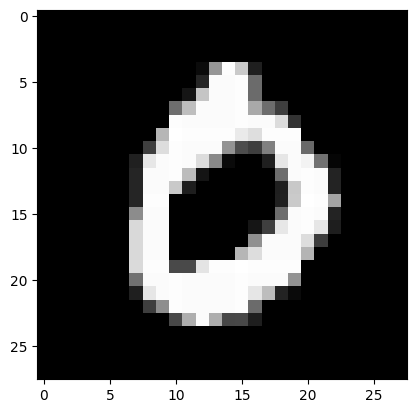

In [8]:
import matplotlib.pyplot as plt
plt.imshow(train.test_dataset_biased[0][0].transpose(0,1).transpose(1,2))

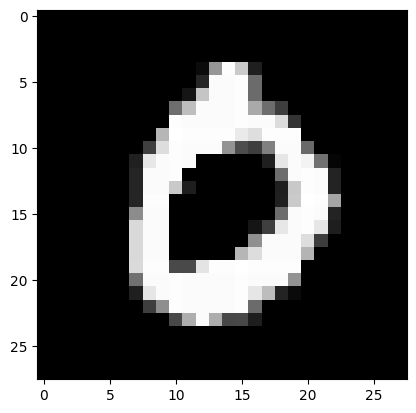

In [9]:
plt.imshow(train.masked_dataset[0][0].transpose(0,1).transpose(1,2))

In [13]:
!rm data -r